In [1]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np
import itertools

from Nback_tasks import NbackTask_PureEM
from Nback_models import PureEM

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [2]:
def run_model(net,gen_data_fn,neps,training=False,verb=False):
  """ gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    if training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score



In [3]:
ntokens=5
cdrift=0.5
cdim=5
sedim=10
indim=cdim+sedim
stsize=20
seed = np.random.randint(1000)

In [4]:
neps = 5000
seqlen=10

In [5]:
nback=1
task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
net = PureEM(nback,indim,stsize,mthresh=.95,seed=seed,debug=False)

gen_rand_trials = lambda: task.gen_ep_data(seqlen)
trsc = run_model(net,gen_rand_trials,neps,training=True,verb=False)

In [6]:
nback=3
task2 = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
net2 = PureEM(nback,indim,stsize,mthresh=.95,seed=seed,debug=False)

gen_rand_trials2 = lambda: task2.gen_ep_data(seqlen)
trsc = run_model(net2,gen_rand_trials2,neps,training=True,verb=False)

(0.5, 1)

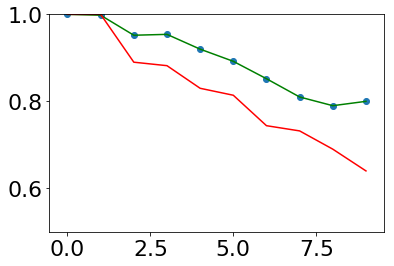

In [7]:
evsc = run_model(net,gen_rand_trials,500,training=False,verb=False)
M = evsc.mean(0)
evsc = run_model(net2,gen_rand_trials2,500,training=False,verb=False)
M2 = evsc.mean(0)
plt.plot(M,c='g')
plt.plot(M2,c='r')
plt.scatter(range(len(M)),M)
plt.ylim(0.5,1)

In [13]:

task2.semat.shape = task.semat.shape

(torch.Size([5, 10]), torch.Size([5, 10]))